In [1]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

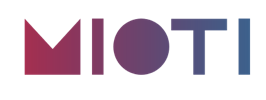
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S2: Aprendizaje no supervisado: PCA

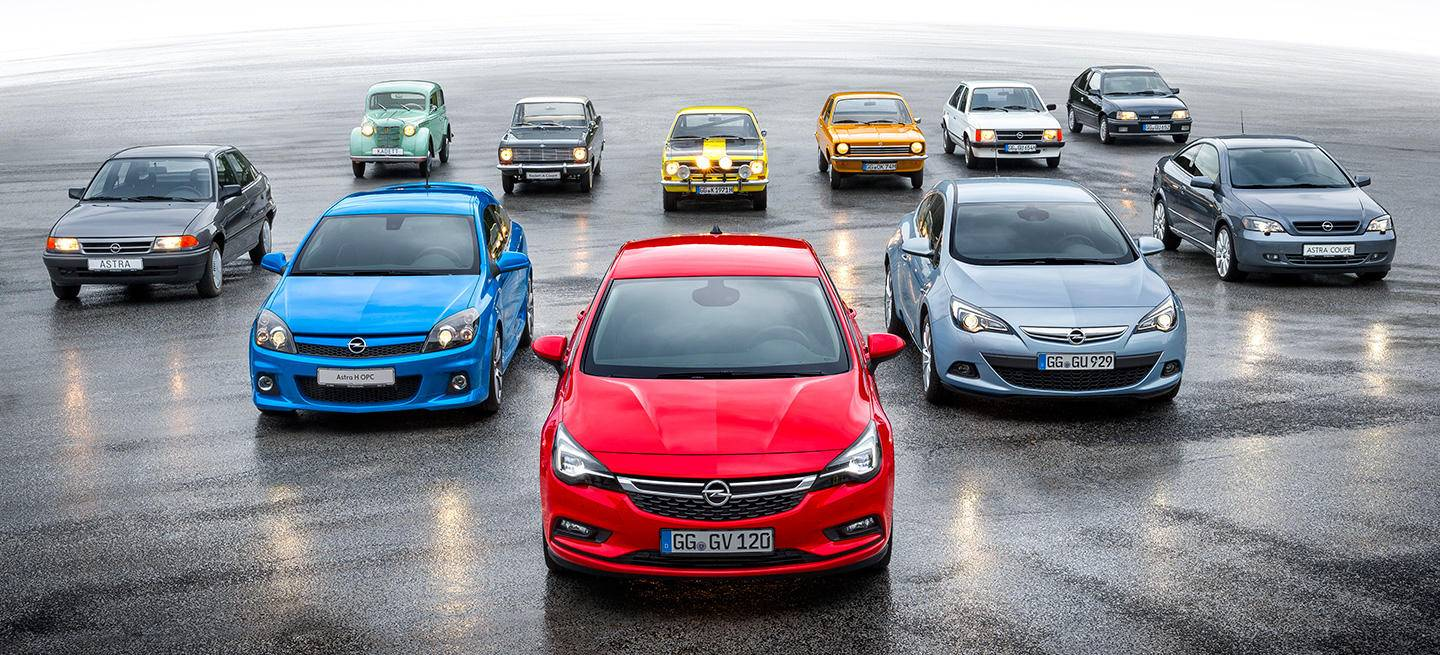

## Objetivos

El objetivo de este challenge es reducir la dimensión de un dataset que dispone de las características de distintos modelos de coches, en especial todoterrenos y turismos.

Para ello, utilizando la técnica de PCA realizaremos una reducción de dimensionalidad de las variables que nos indican las características (tamaño del motor, distancia entre ejes, longitud, anchura, ...) y posteriormente veremos si quedan identificados los todoterrenos y turismos.

### Importando y preparando dataset

In [2]:
#importamos las librerías
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
coche=pd.read_csv('Car_sales.csv')
coche.head()

Manufacturer              Model  Sales in thousands 4-year resale value  \
0  Acura          Integra                        16.919               16.36   
1  Acura          TL                             39.384              19.875   
2  Acura          CL                             14.114              18.225   
3  Acura          RL                              8.588              29.725   
4  Audi           A4                             20.397              22.255   

  Vehicle type Price in thousands Engine size Horsepower Wheelbase Width  \
0    Passenger               21.5         1.8        140     101.2  67.3   
1    Passenger               28.4         3.2        225     108.1  70.3   
2    Passenger                  .         3.2        225     106.9  70.6   
3    Passenger                 42         3.5        210     114.6  71.4   
4    Passenger              23.99         1.8        150     102.6  68.2   

  Length Curb weight Fuel capacity Fuel efficiency Latest Launch  
0  172.4       2.639          13.2              28      2-Feb-14  
1  192.9       3.517          17.2              25      6-Mar-15  
2    192        3.47          17.2              26      1-Apr-14  
3  196.6        3.85            18              22      3-Oct-15  
4    178       2.998          16.4              27     10-Aug-15

#### Podemos observar que en este dataset los nombres de las variables vienen con espacios, así como observamos que hay datos que vienen como '.' 

In [4]:
coche = coche.rename(columns={'Sales in thousands':'Sales_in_thousands','4-year resale value':'4_year_resale_value','Vehicle type':'Vehicle_type','Price in thousands':'Price_in_thousands','Engine size':'Engine_size','Curb weight':'Curb_weight','Fuel capacity':'Fuel_capacity','Fuel efficiency':'Fuel_efficiency','Latest Launch':'Latest_Launch'})
coche=coche.replace('.','NaN')

#### Vamos a ver ahora la información del dataset

In [5]:
coche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 15 columns):
Manufacturer           157 non-null object
Model                  157 non-null object
Sales_in_thousands     157 non-null float64
4_year_resale_value    157 non-null object
Vehicle_type           157 non-null object
Price_in_thousands     157 non-null object
Engine_size            157 non-null object
Horsepower             157 non-null object
Wheelbase              157 non-null object
Width                  157 non-null object
Length                 157 non-null object
Curb_weight            157 non-null object
Fuel_capacity          157 non-null object
Fuel_efficiency        157 non-null object
Latest_Launch          157 non-null object
dtypes: float64(1), object(14)
memory usage: 18.5+ KB


#### Observamos que varias de nuestras columnas que deberían ser float son realmente object

In [6]:
coche[['4_year_resale_value','Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency']]=coche[['4_year_resale_value','Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency']].astype(float)

#### Vamos ahora a eliminar los duplicados y comprobar cuantos había

In [7]:
coche = coche.drop_duplicates()
coche.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 156
Data columns (total 15 columns):
Manufacturer           157 non-null object
Model                  157 non-null object
Sales_in_thousands     157 non-null float64
4_year_resale_value    121 non-null float64
Vehicle_type           157 non-null object
Price_in_thousands     155 non-null float64
Engine_size            156 non-null float64
Horsepower             156 non-null float64
Wheelbase              156 non-null float64
Width                  156 non-null float64
Length                 156 non-null float64
Curb_weight            155 non-null float64
Fuel_capacity          156 non-null float64
Fuel_efficiency        154 non-null float64
Latest_Launch          157 non-null object
dtypes: float64(11), object(4)
memory usage: 19.6+ KB


#### En nuestro dataset no había datos duplicados, continuaremos ahora con los missing data

In [8]:
coche.isna().sum()

Manufacturer            0
Model                   0
Sales_in_thousands      0
4_year_resale_value    36
Vehicle_type            0
Price_in_thousands      2
Engine_size             1
Horsepower              1
Wheelbase               1
Width                   1
Length                  1
Curb_weight             2
Fuel_capacity           1
Fuel_efficiency         3
Latest_Launch           0
dtype: int64

#### Observamos que tenemos 36 missing data en 4_year_resale_value,2 en Price_in_thousands y Curb_weight, 3 en Fuel_efficiency y 1 en Engine_size,Horsepower, Wheelbase, Width,Length,y Fuel_capacity.
### Vamos ahora a cambiar los missing data por el valor de la mediana

In [9]:
coche = coche.fillna(coche.median())

Ya estamos casi a punto de aplicar PCA, antes algunas revisiones previas:
- Verificar que la escala de medida de las variables es similar y sino es así aplicar alguna técnica para conseguirlo.
- Revisar la correlación entre las variables y son las que tienen relación las que aportaran una mayor reducción de la dimensión.

In [10]:
#lo hacemos en el paso siguiente ya que lo tenemos que hacer sin dos de las filas

#### Vamos a guardar la información de 2 observaciones, una de cada tipo de coche para luego comprobar en que grupo quedarían localizadas (por ejemplo la primera observación y la 84)

In [11]:
coche1 = coche[['4_year_resale_value', 'Price_in_thousands', 'Engine_size', 'Horsepower','Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity','Fuel_efficiency']]

In [52]:
coche_test = np.array([[coche1.iloc[0]], [coche1.iloc[83]]])
coche_test

array([[[ 19.875,  28.4  ,   3.2  , 225.   , 108.1  ,  70.3  , 192.9  ,
           3.517,  17.2  ,  25.   ]],

       [[ 13.88 ,  22.527,   3.   , 173.   , 107.3  ,  66.7  , 178.3  ,
           3.51 ,  19.5  ,  20.   ]]])

In [13]:
coche = coche.drop([0], axis=0)
coche = coche.drop([83], axis=0)

In [14]:
coche.shape

(155, 15)

#### Ahora sí, vamos a crear el dataset con las variables a las que les vamos a realizar el PCA

Ya se ha creado anteriormente (al normalizar el dataset)

In [15]:
cochepca = coche[['4_year_resale_value', 'Price_in_thousands', 'Engine_size', 'Horsepower','Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity','Fuel_efficiency']]

## Comenzamos con el método PCA

### En primer lugar, seleccionando las componentes por el método del codo

La idea es buscar un codo en el gráfico entre las componentes y la varianza explicada, es decir, un punto a partir del cual el incremento de información explicada es casi la misma. El criterio es quedarse con un número de componentes que excluya los asociados a valores pequeños y aproximadamente del mismo tamaño.


In [16]:
#Se ha normalizado todo en el paso anterior; nuestro array normalizado es cochepca
scaler = StandardScaler()
Coche_normalizado = scaler.fit_transform(cochepca)
Coche_normalizado

array([[ 0.2658704 ,  0.07115613,  0.12596683, ...,  0.21281296,
        -0.19804969,  0.2741629 ],
       [ 0.10421103, -0.32035479,  0.12596683, ...,  0.13765213,
        -0.19804969,  0.51024761],
       [ 1.23092783,  1.0217986 ,  0.41451155, ...,  0.74533543,
         0.00884299, -0.43409125],
       ...,
       [-0.29209935,  0.0991162 , -0.64348575, ..., -0.19977202,
        -0.01701859,  0.2741629 ],
       [-0.29209935,  1.26644923, -0.73966733, ...,  0.34714295,
         0.13815092, -0.19800654],
       [-0.29209935,  0.60239751, -0.16257789, ...,  0.34554379,
         0.81055216,  0.03807818]])

### Aplicamos PCA con 10 componentes inicialmente

y luego seleccionamos las mínimas necesarias. Primero aplicamos PCA:

In [17]:
pca = PCA(n_components=10)
pca.fit(Coche_normalizado)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
dataset_X_pca = pca.transform(cochepca)
dataset_X_pca.shape

(155, 10)

y a continuación revisamos la varianza explicada, para ello dibujamos una gráfica entre componentes y varianza acumulada

In [19]:
#explained variance en la funcion de PCA
explained_variance = pca.explained_variance_
print(explained_variance)

[6.01178246 2.03812946 0.67019684 0.40507925 0.25825494 0.22229021
 0.15604638 0.14109141 0.10173583 0.06032829]


In [20]:
np.sum(pca.explained_variance_)

10.064935064935062

In [21]:
explained_variance = pca.explained_variance_ / np.sum(pca.explained_variance_)
explained_variance

array([0.59729968, 0.20249802, 0.0665873 , 0.04024658, 0.02565888,
       0.02208561, 0.01550396, 0.01401811, 0.01010795, 0.00599391])

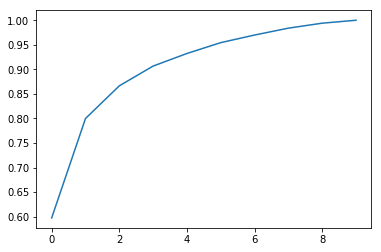

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [23]:
np.cumsum(pca.explained_variance_ratio_)

array([0.59729968, 0.7997977 , 0.866385  , 0.90663158, 0.93229046,
       0.95437607, 0.96988003, 0.98389815, 0.99400609, 1.        ])

##### ¿Con cuantas componentes superamos el 85%?  ¿ y esas componentes cuánto aportan realmente?

Lo superamos a partir de tres componentes. El resto tienen una varianza entre el 15 y el 0%.

##### Aplicamos el PCA con el número de componentes que nos ha parecido razonable y graficamos si es posible

In [24]:
/

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
dataset_X_pca = pca.transform(cochepca)
dataset_X_pca.shape

(155, 2)

In [26]:
dataset_X_pca

array([[-194.30424463,  -34.62270139],
       [-191.60719488,  -37.33606406],
       [-199.75269218,  -32.39492458],
       [-160.68609718,  -51.86569347],
       [-191.47198065,  -39.66182877],
       [-243.39107982,   13.49571068],
       [-168.07796657,  -49.49118088],
       [-181.03839702,  -31.25299531],
       [-189.76851598,  -31.5624293 ],
       [-176.20072247,  -59.47849747],
       [-200.23026183,  -36.46705165],
       [-196.88796335,  -47.82377193],
       [-190.90576492,  -49.8286315 ],
       [-224.07935873,  -20.61238285],
       [-223.49247393,  -12.54927764],
       [-221.15200456,  -13.82198858],
       [-188.13745947,  -43.024098  ],
       [-224.72687211,  -29.56659205],
       [-144.17398003,  -76.50941969],
       [-168.99360938,  -60.8965011 ],
       [-175.93220319,  -63.5248554 ],
       [-177.56332571,  -61.26326913],
       [-183.08965951,  -46.1774531 ],
       [-240.49556105,   27.07563146],
       [-139.03600079,  -68.87709248],
       [-100.34503654,  -

In [27]:
#explained variance en la funcion de PCA
explained_variance = pca.explained_variance_
print(explained_variance)

[6.01178246 2.03812946]


In [28]:
explained_variance = pca.explained_variance_ / np.sum(pca.explained_variance_)
explained_variance

array([0.74681345, 0.25318655])

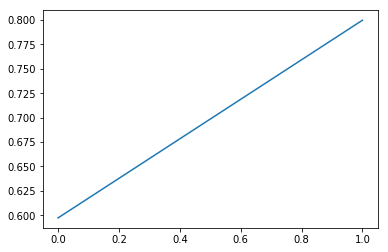

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

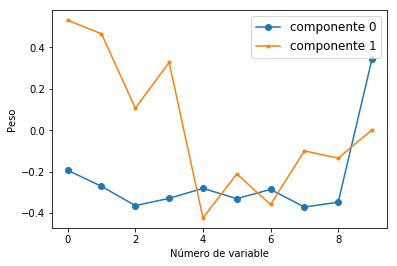

In [30]:
plt.plot(range(0, 10), pca.components_[0], marker='o', label='componente 0')
plt.plot(range(0, 10), pca.components_[1], marker='.', label='componente 1')

plt.xlabel('Número de variable')
plt.ylabel('Peso')
plt.legend(prop=dict(size=12))
plt.show()

##### Y como podemos observar hemos podido disminuir las dimensiones de 10 variables inicialmente a solo algunas componentes

####  Para realizar la gráfica y aunque PCA se usa en no supervisada (es decir sin etiquetas), para verlo mejor vamos a dibujar los coches diferenciándolos entre 'Passenger' y 'Car' tal y como vienen en 'Vehicles_types'

In [31]:
y = coche['Vehicle_type']
y = y.replace("Passenger", 1)
y = y.replace("Car", 0)
y = np.array(y)

In [32]:
def dibuja_digitos(X, y, font_size=9):
    colors = ["#476A2A", "#7851B8"]
    plt.figure(figsize=(16, 10))
    plt.xlim(X[:, 0].min(), X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min(), X[:, 1].max() + 1)
    
    for i in range(len(X)):
        # actually plot the digits as text instead of using scatter
        clr = colors[y[i]]
        fd = {'weight': 'bold', 'size': font_size}
        plt.text(X[i, 0], X[i, 1], str(y[i]), color = clr, fontdict=fd)

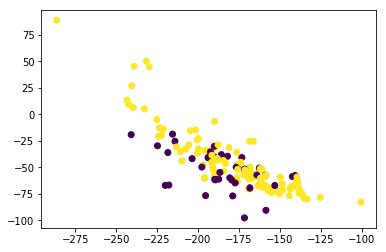

In [33]:
plt.scatter(dataset_X_pca[:, 0], dataset_X_pca[:, 1], c=y)

### ¿Consigues ver los grupos separados en la gráfica?

Como podemos observar en la gráfica, ambos grupos no pueden categorizarse correctamente ya que se encuentran muy juntos y sobre el mismo espacio más o menos.

## Predeterminando la cantidad de información de las componentes

####  En segundo lugar, seleccionando las componentes que me aportan el 80% de la información

In [34]:
#Seleccionando el 0.8 le estamos diciendo que queremos que la varianza explicada acumulada sea superior al 80% con el mínimo de componentes.
pca = PCA(n_components=0.8)
pca.fit(Coche_normalizado)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
dataset_X_pca = pca.transform(cochepca)
dataset_X_pca.shape

(155, 3)

In [36]:
explained_variance = pca.explained_variance_
print(explained_variance)

[6.01178246 2.03812946 0.67019684]


In [37]:
explained_variance = pca.explained_variance_ / np.sum(pca.explained_variance_)
explained_variance

array([0.689416  , 0.23372753, 0.07685648])

#### ¿Cuantas componentes principales obtenemos en este caso? ¿Cuanta varianza acumulada proporcionan? Grafica los resultados

En este caso obtenemos 3 componentes principales que proporcionan una varianza acumulada igual a 1.

In [38]:
np.sum(explained_variance)

1.0000000000000002

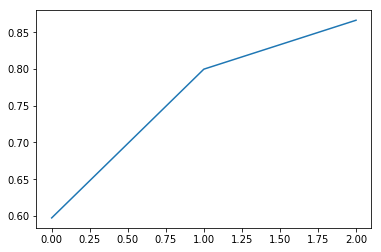

In [39]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

##### Podemos comprobar que en efecto su porcentaje supera el 80%

#### ¿Es posible con esta gráfica hacer una gran distinción entre car y passenger?

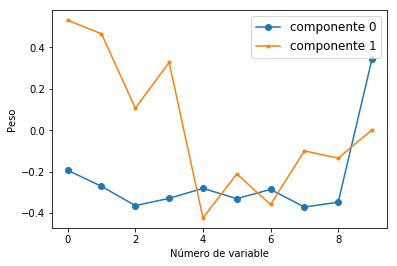

In [40]:
plt.plot(range(0, 10), pca.components_[0], marker='o', label='componente 0')
plt.plot(range(0, 10), pca.components_[1], marker='.', label='componente 1')

plt.xlabel('Número de variable')
plt.ylabel('Peso')
plt.legend(prop=dict(size=12))
plt.show()

In [41]:
coche_test

array([[[ 16.36 ,  21.5  ,   1.8  , 140.   , 101.2  ,  67.3  , 172.4  ,
           2.639,  13.2  ,  28.   ]],

       [[ 20.94 ,  25.45 ,   3.   , 161.   ,  97.2  ,  72.4  , 180.3  ,
           3.131,  19.8  ,  21.   ]]])

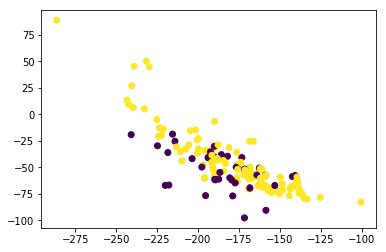

In [42]:
plt.scatter(dataset_X_pca[:, 0], dataset_X_pca[:, 1], c=y)

## ¿Distinguimos el grupo de las dos observaciones test?

#### Para ello accedemos a la página de scikit.sklearn para ver como estandariza StandardScaler y nos fijamos que la forma de estandarizar es: 
###### z = (x - u) / s siendo u la media y s la desv.tipica.

In [43]:
mean = np.array(scaler.mean_)
print(mean)

[ 17.16135484  27.38203226   3.06903226 186.3516129  107.59096774
  71.16290323 187.48903226   3.38392258  17.96580645  23.83870968]


In [44]:
desv = np.array(scaler.var_)

print(desv)

[1.04175632e+02 2.04664912e+02 1.08097648e+00 3.19758766e+03
 5.74424991e+01 1.18118658e+01 1.78632073e+02 3.91032265e-01
 1.49516695e+01 1.79417274e+01]


#### De esta manera hemos estandarizado los datos al igual que si hubiesen estado en el dataset original

In [45]:
coche_test.shape

(2, 1, 10)

In [56]:
coche_test_est = (coche_test - mean) / desv
coche_test_est = coche_test_est.transpose([1,0,2]).reshape(2,10)
coche_test_est.shape

(2, 10)

#### Ahora ya le hemos aplicado las PCA a ambas pruebas y proseguimos con la gráfica

In [53]:
pcatest = PCA(n_components=2)
pcatest.fit(coche_test_est)
dataset_X_test = pcatest.transform(coche_test_est)
dataset_X_test.shape

(2, 2)

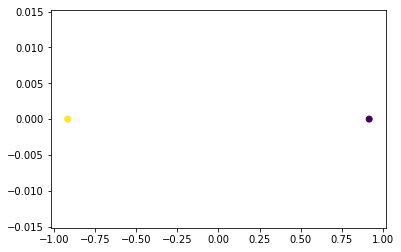

In [48]:
plt.scatter(dataset_X_test[:, 0], dataset_X_test[:, 1], c=[1, 0])

#### ¿Podríamos clasificar a nuestras 2 observaciones de test entre los 2 tipos de vehículos?

Se observa que tenemos ambas observaciones cada una a una lado de la gráfica. Una está más cerca de -1 mientras que la otra se aproxima a 1; por lo que podríamos clasificarlas como diferentes tipos, pero en mi opinión, mirando los resultados anteriores, no quedaría claro a qué tipo de coche ya que en las gráficas de entrenamiento los puntos están muy juntos.

## ¿Qué relación tienen las componentes con las variables?

#### Utiliza un indicador que nos permita identificar las relaciones entre variables y componentes

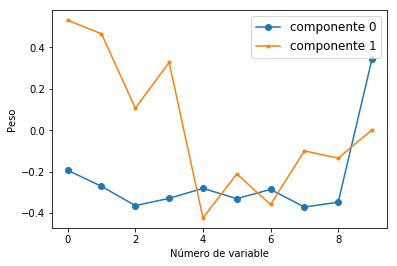

In [49]:
plt.plot(range(0, 10), pca.components_[0], marker='o', label='componente 0')
plt.plot(range(0, 10), pca.components_[1], marker='.', label='componente 1')

plt.xlabel('Número de variable')
plt.ylabel('Peso')
plt.legend(prop=dict(size=12))
plt.show()

#### ¿Qué variables aportan mas a cada componente?

In [50]:
coche1 = coche[['4_year_resale_value', 'Price_in_thousands', 'Engine_size', 'Horsepower','Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity','Fuel_efficiency']]

- Componente 0 (Tipo de coche Car): Las variables que más aportan son '4_year_resale_value', 'Price_in_thousands' y 'Engine_size'
- Componente 1 (Tipo de coche Passenger): La variable que más aporta es Fuel efficiency

## Como conclusiones y reflexiones:

* ¿Se te ocurren aplicaciones concretas de PCA en tu entorno?

El principal objetivo de PCA es analizar los datos e intentar encontrar la estructura subyacente, por lo que las principales aplicaciones que se me ocurren son las de detección de intrusos, por ejemplo en ciberseguridad, detección de defectos de fabricación en procesos industriales o predicción de ganancias en el mercado de valores.


* ¿En qué situaciones deberíamos ser cuidadosos antes de aplicar PCA?

Cuando la correlación entre variables es baja, ya que si esta correlación no es alta PCA no será efectivo.